In [7]:
# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
import joblib # Used for encoding horse_id
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as viz
from catboost import CatBoostRanker, CatBoostRegressor, CatBoostClassifier, Pool
import numpy as np
import itertools
import pyspark.sql.functions as F
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment 
# Set global references to None
spark = None
master_results_df = None
race_df = None
df = None
training_data = None
train_df = None

In [8]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [202]:
train_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/train_df")
global_speed_score = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/global_speed_score.parquet")
horse_embedding = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/horse_embedding_data-20250329_1353.parquet")
# df = pd.read_parquet(f"{parquet_dir}exacta_bet_results.parquet")

In [203]:
# Filter the DataFrame for the specific race
filtered_df = horse_embedding.filter(
    (col("course_cd") == "LRL") &
    (col("race_date") == "2025-03-28") &
    (col("race_number") == 3)
)

# Show the results
filtered_df.show()

+---------+----------+-----------+------------------+------------+---------+--------------------+----------------+-------------------+-------------------+----------------+------------+-----------------+-------------+--------------------+------------+------------------+------------------+-----------------+-----------------+-----------------+-------------+-------------+-------------+-------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+-------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+-----------------+--------------+----

In [158]:
df.columns

Index(['course_cd', 'race_date', 'race_number', 'surface', 'distance_meters',
       'track_condition', 'avg_purse_val_calc', 'race_type', 'base_amount',
       'combos_generated', 'cost', 'payoff', 'net', 'hit_flag',
       'actual_winning_combo', 'generated_combos', 'roi', 'field_size'],
      dtype='object')

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_bet_results(df: pd.DataFrame):
    """
    df has columns like:
      ['course_cd', 'race_date', 'race_number', 'surface', 'distance_meters',
       'track_condition', 'base_amount', 'combos_generated', 'cost', 'payoff',
       'net', 'hit_flag', 'actual_winning_combo', 'generated_combos', 'roi']
    This function performs some example groupby analyses and plots.
    """

    # 1) Check overall summary
    print("DataFrame Summary:")
    print(df.describe())
    print("\nSample Rows:")
    print(df.head())

    # 2) Average ROI by surface
    surf_roi = df.groupby("surface")["roi"].mean().sort_values(ascending=False)
    print("\nAverage ROI by Surface:\n", surf_roi)

    # 3) Average hit rate by track condition
    # (hit_flag = 1 if you won, 0 if lost)
    cond_hit = df.groupby("track_condition")["hit_flag"].mean().sort_values(ascending=False)
    print("\nHit Rate by Track Condition:\n", cond_hit)

    # 4) Example bar plot: ROI by surface
    plt.figure(figsize=(8,5))
    surf_roi.plot(kind='bar', color='skyblue')
    plt.title("Average ROI by Surface")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.show()

    # 5) Example bar plot: Hit rate by track condition
    plt.figure(figsize=(8,5))
    cond_hit.plot(kind='bar', color='orange')
    plt.title("Hit Rate by Track Condition")
    plt.ylabel("Hit Rate (0-1)")
    plt.tight_layout()
    plt.show()

    # 6) Distribution of net profit/loss per race
    plt.figure(figsize=(8,5))
    sns.histplot(df["net"], bins=50, kde=True, color='green')
    plt.title("Distribution of Net Gains/Losses")
    plt.xlabel("Net ($)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # 7) If you suspect distance is important, bin distance into categories:
    df["distance_bin"] = pd.cut(df["distance_meters"], bins=[0,1200,1600,2000,99999],
                                labels=["Sprint","Mile-ish","Mid","Long"])
    dist_roi = df.groupby("distance_bin")["roi"].mean().sort_values(ascending=False)
    print("\nAverage ROI by Distance Bin:\n", dist_roi)

    plt.figure(figsize=(8,5))
    dist_roi.plot(kind='bar', color='purple')
    plt.title("Average ROI by Distance Bin")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.show()

    # 8) Additional ideas:
    #    - ROI or hit_rate by course_cd
    #    - net distribution by surface
    #    - combos_generated vs. net

    print("\nAnalysis complete. See plots for details.")

DataFrame Summary:
       race_number  distance_meters  base_amount  combos_generated    cost  \
count  7810.000000      7810.000000       7810.0            7810.0  7810.0   
mean      5.360563      1441.094238          2.0               2.0     4.0   
std       2.830026       277.260829          0.0               0.0     0.0   
min       1.000000      1006.000000          2.0               2.0     4.0   
25%       3.000000      1207.000000          2.0               2.0     4.0   
50%       5.000000      1408.000000          2.0               2.0     4.0   
75%       8.000000      1609.000000          2.0               2.0     4.0   
max      14.000000      3822.000000          2.0               2.0     4.0   

            payoff          net     hit_flag          roi   field_size  
count  7810.000000  7810.000000  7810.000000  7810.000000  7810.000000  
mean     17.016935    13.016935     0.327657     3.254234     7.213700  
std      50.307666    50.307666     0.469389    12.576917  

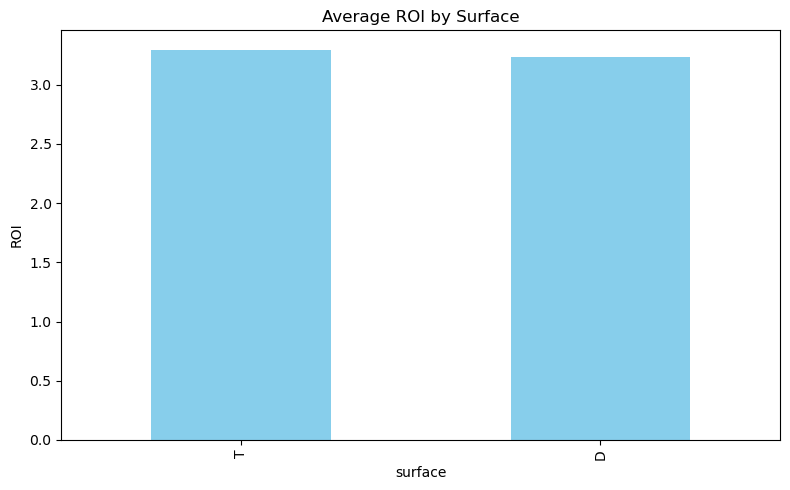

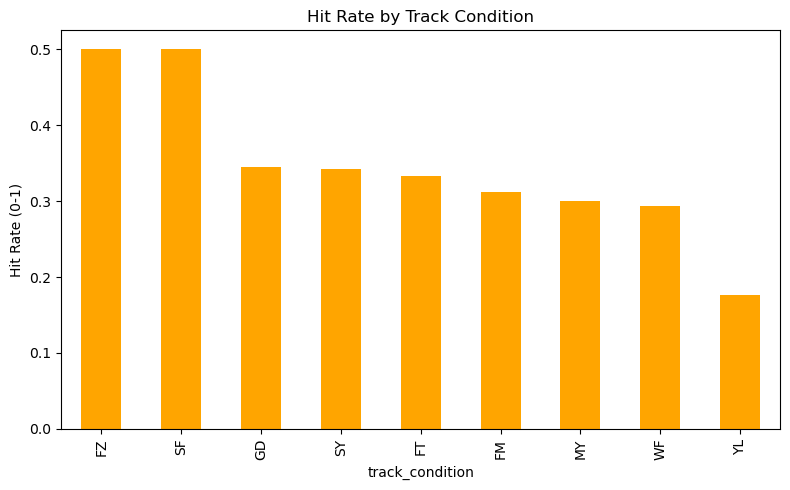

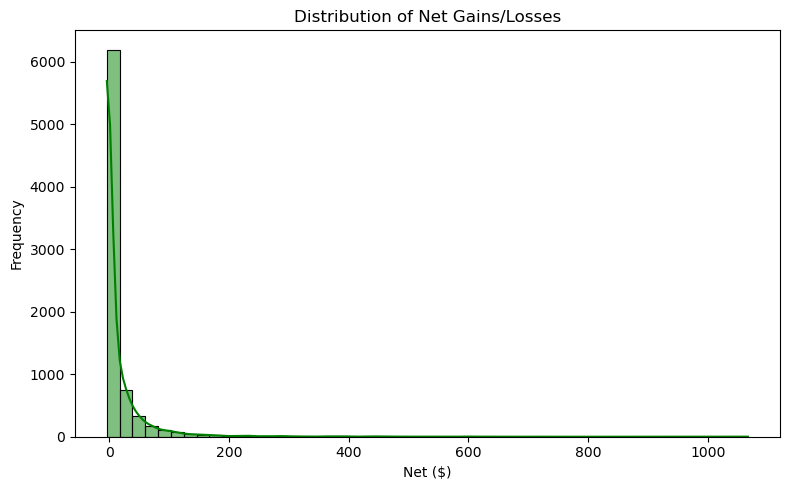


Average ROI by Distance Bin:
 distance_bin
Mile-ish    3.522332
Mid         3.216596
Sprint      2.763566
Long        2.579449
Name: roi, dtype: float64


/tmp/ipykernel_1826254/673712600.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_roi = df.groupby("distance_bin")["roi"].mean().sort_values(ascending=False)


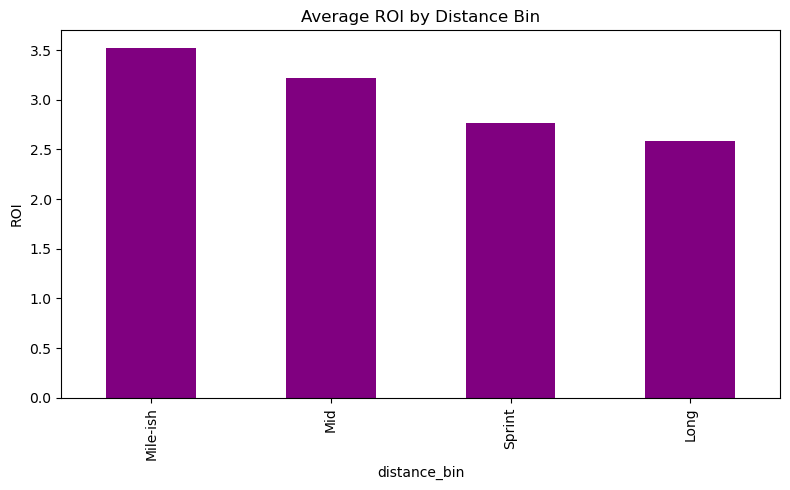


Analysis complete. See plots for details.


In [160]:
analyze_bet_results(df)

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extended_analyze_bet_results(df: pd.DataFrame):
    """
    df has columns like:
      ['course_cd', 'race_date', 'race_number', 'surface', 'distance_meters',
       'track_condition', 'base_amount', 'combos_generated', 'cost', 'payoff',
       'net', 'hit_flag', 'actual_winning_combo', 'generated_combos', 'roi']
    This function adds more EDA/visuals for:
      - ROI or hit_rate by course_cd
      - net distribution by surface
      - combos_generated vs net
    """

    # =========== 1) ROI or Hit Rate by course_cd ===========
    # Example: average ROI by track (course_cd)
    course_roi = df.groupby("course_cd")["roi"].mean().sort_values(ascending=False)
    print("\nAverage ROI by Course:\n", course_roi)

    plt.figure(figsize=(10,6))
    course_roi.plot(kind='bar', color='teal')
    plt.title("Average ROI by Course")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.show()

    # Alternatively, you can do hit rate if you prefer:
    # course_hit_rate = df.groupby("course_cd")["hit_flag"].mean().sort_values(ascending=False)
    # ... or do both and compare.

    # =========== 2) Net Distribution by surface ===========
    # We'll create a boxplot or violinplot to see how net profit/loss distribution
    # differs by surface (e.g. Dirt, Turf, Synthetic, etc.)
    plt.figure(figsize=(8,6))
    sns.boxplot(x="surface", y="net", data=df, showfliers=False)
    plt.title("Net Distribution by Surface (Outliers Hidden)")
    plt.ylabel("Net ($)")
    plt.xlabel("Surface")
    plt.tight_layout()
    plt.show()

    # If you have many surfaces or outliers, a violinplot might be interesting too:
    plt.figure(figsize=(8,6))
    sns.violinplot(x="surface", y="net", data=df, cut=0)
    plt.title("Net Distribution by Surface (Violin Plot)")
    plt.ylabel("Net ($)")
    plt.xlabel("Surface")
    plt.tight_layout()
    plt.show()

    # =========== 3) combos_generated vs net ===========
    # We can do a scatter plot or strip plot to see if there's any correlation 
    # between how many combos we generate and our net result.
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="combos_generated", y="net", data=df, color='purple')
    plt.title("Combos Generated vs. Net Profit/Loss")
    plt.xlabel("Number of Combos Generated")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

    # Alternatively, a strip plot or box plot:
    plt.figure(figsize=(8,6))
    sns.stripplot(x="combos_generated", y="net", data=df, size=4, alpha=0.6)
    plt.title("Combos Generated vs. Net Profit/Loss (Strip Plot)")
    plt.xlabel("Number of Combos Generated")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

    print("\nExtended Analysis complete.")


Average ROI by Course:
 course_cd
TKD    7.585192
KEE    5.791395
TOP    5.125424
TTP    4.850299
TWO    4.102310
IND    3.690449
HOU    3.648851
AQU    3.614075
MVR    3.479412
TAM    3.302338
TGP    3.250621
MTH    3.026471
TLS    2.815323
ELP    2.777443
SAR    2.441396
TSA    2.391709
LRL    2.341074
DMR    2.207353
CNL    1.955324
TCD    1.925909
CBY    1.773760
PEN    1.170918
Name: roi, dtype: float64


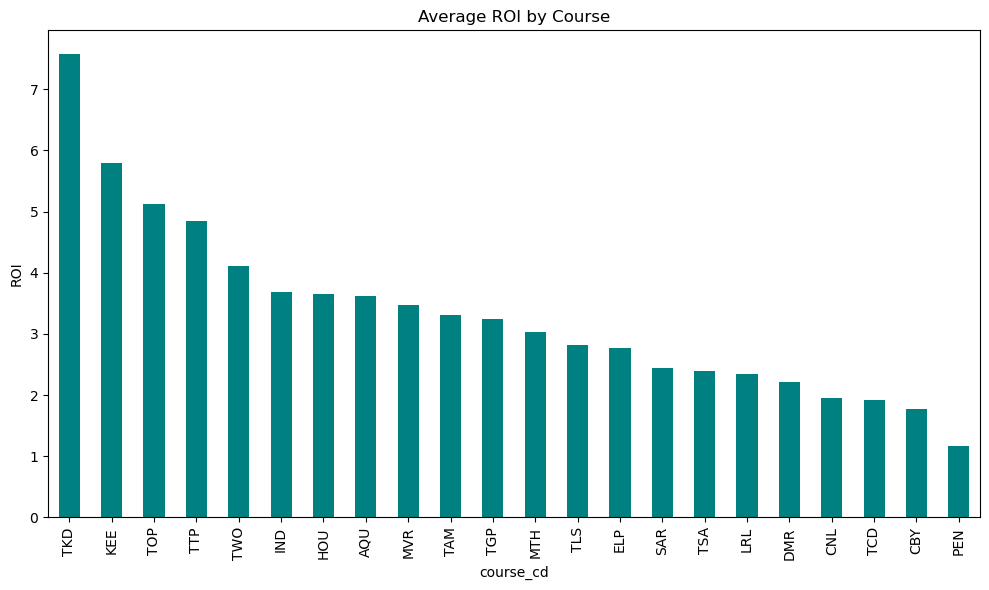

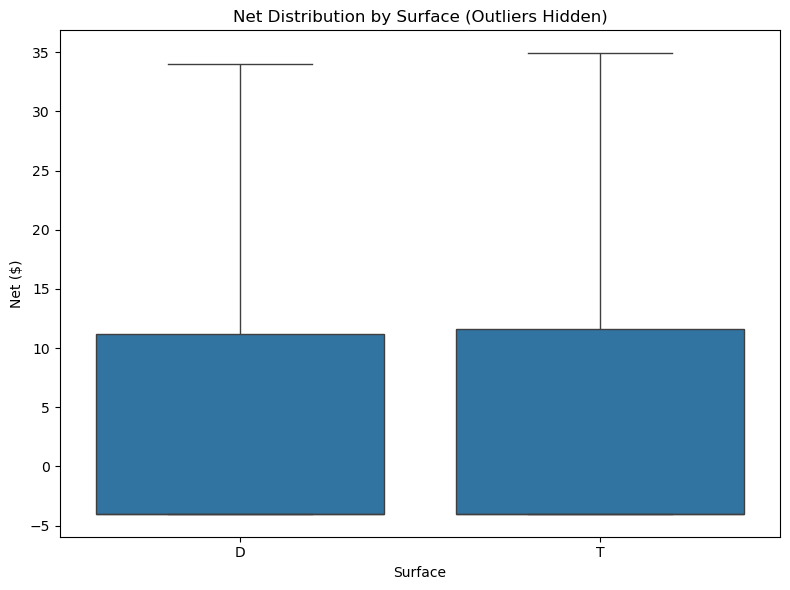

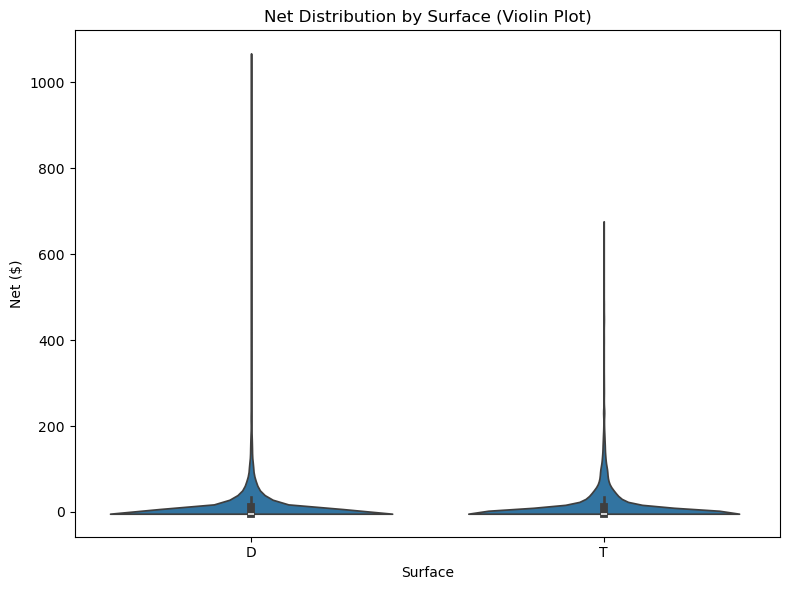

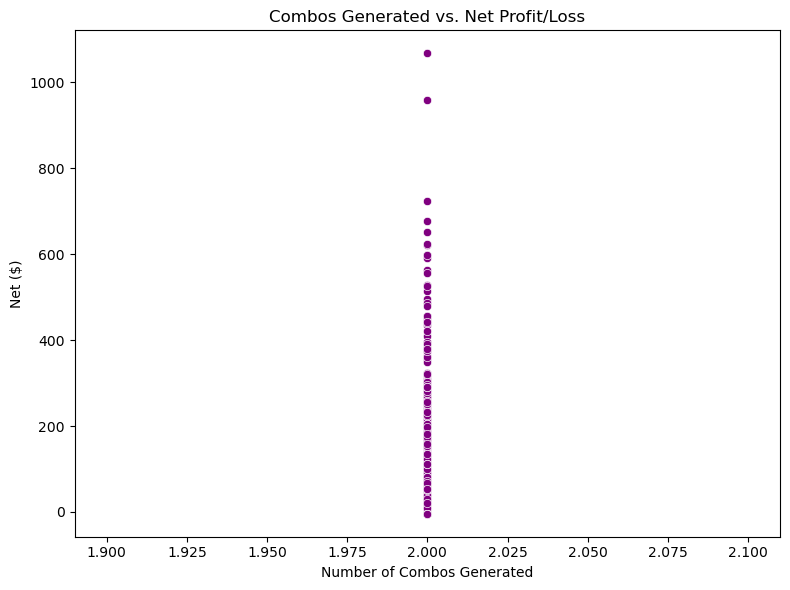

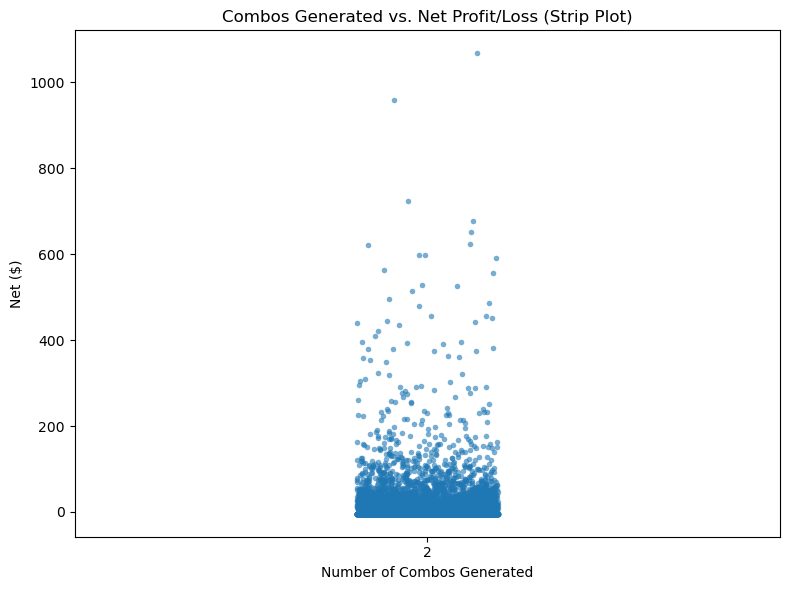


Extended Analysis complete.


In [162]:
extended_analyze_bet_results(df)

In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_purse_values(df: pd.DataFrame):
    """
    Analyzes the 'avg_purse_val_calc' column in relation to
    net profit, ROI, and hit rate. Assumes df includes:
      'avg_purse_val_calc', 'net', 'roi', 'hit_flag', etc.
    """

    # 1) Basic distribution of avg_purse_val_calc
    plt.figure(figsize=(8,5))
    sns.histplot(df["avg_purse_val_calc"].dropna(), bins=30, kde=True, color='green')
    plt.title("Distribution of Average Purse Value")
    plt.xlabel("avg_purse_val_calc")
    plt.tight_layout()
    plt.show()

    # 2) Create purse "bins" so we can group by categories (adjust bins as needed)
    # For example, if values are typically between 0 and 3, create custom intervals
    # Replace with your real ranges if you have bigger or smaller purses
    bins = [0, 0.5, 1.0, 1.5, 2.0, 9999]
    labels = ["VeryLow","Low","Mid","High","VeryHigh"]
    df["purse_bin"] = pd.cut(df["avg_purse_val_calc"], bins=bins, labels=labels)

    # 3) Mean ROI by purse_bin
    purse_roi = df.groupby("purse_bin")["roi"].mean().sort_values(ascending=False)
    print("\nAverage ROI by Purse Bin:\n", purse_roi)

    plt.figure(figsize=(8,5))
    purse_roi.plot(kind='bar', color='skyblue')
    plt.title("Average ROI by Purse Bin")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.show()

    # 4) Mean Hit Rate by purse_bin
    purse_hit_rate = df.groupby("purse_bin")["hit_flag"].mean().sort_values(ascending=False)
    print("\nHit Rate by Purse Bin:\n", purse_hit_rate)

    plt.figure(figsize=(8,5))
    purse_hit_rate.plot(kind='bar', color='coral')
    plt.title("Hit Rate by Purse Bin")
    plt.ylabel("Hit Rate (0-1)")
    plt.tight_layout()
    plt.show()

    # 5) Optional: check correlation between avg_purse_val_calc and net or ROI
    # (only valid if these are numeric and not heavily skewed by outliers)
    corr_net = df["avg_purse_val_calc"].corr(df["net"])
    corr_roi = df["avg_purse_val_calc"].corr(df["roi"])
    print(f"\nCorrelation with net: {corr_net:.3f}")
    print(f"Correlation with ROI: {corr_roi:.3f}")

    # 6) Scatter plot: purse value vs. net
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="avg_purse_val_calc", y="net", data=df)
    plt.title("Scatter Plot: Purse Value vs. Net")
    plt.xlabel("avg_purse_val_calc")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

    # Cleanup: remove the 'purse_bin' column if you want to keep df pristine
    # df.drop(columns=["purse_bin"], inplace=True)

    print("\nAnalysis of avg_purse_val_calc completed.")

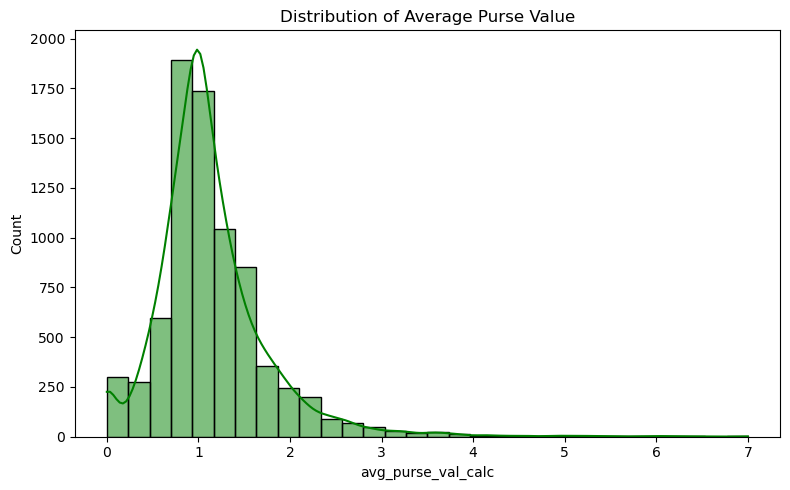


Average ROI by Purse Bin:
 purse_bin
VeryHigh    3.694747
VeryLow     3.612454
High        3.428790
Low         3.167653
Mid         3.023563
Name: roi, dtype: float64


/tmp/ipykernel_1826254/1944492182.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purse_roi = df.groupby("purse_bin")["roi"].mean().sort_values(ascending=False)


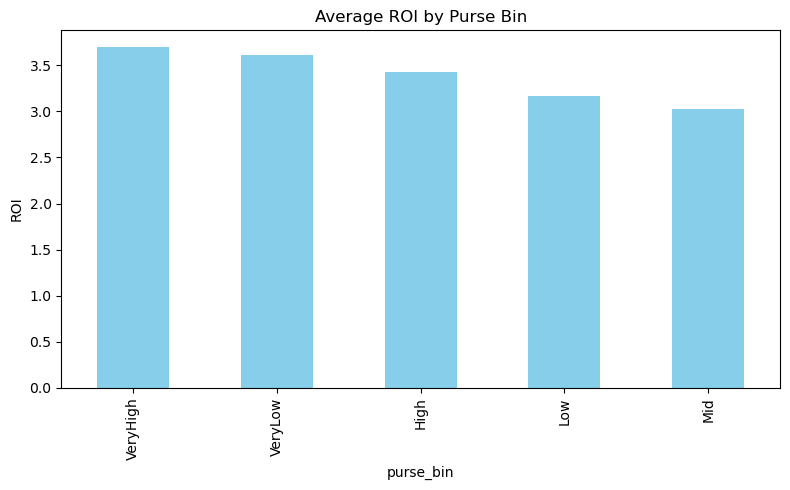


Hit Rate by Purse Bin:
 purse_bin
VeryHigh    0.375486
Low         0.327151
Mid         0.320914
High        0.320293
VeryLow     0.311148
Name: hit_flag, dtype: float64


/tmp/ipykernel_1826254/1944492182.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purse_hit_rate = df.groupby("purse_bin")["hit_flag"].mean().sort_values(ascending=False)


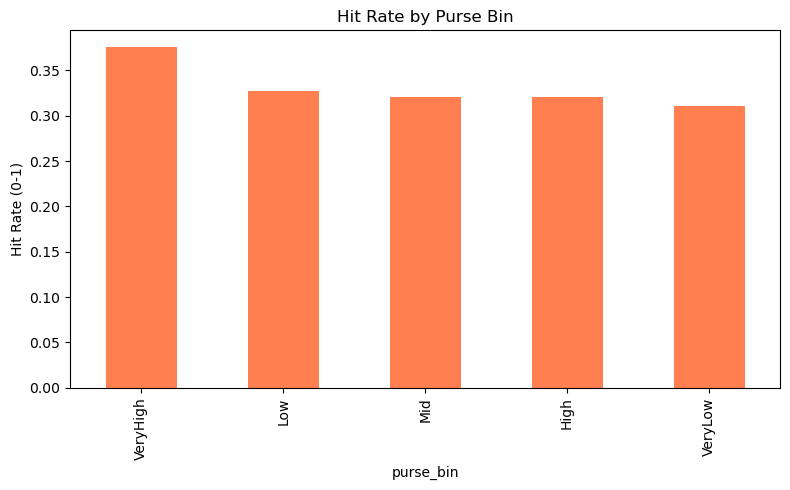


Correlation with net: -0.002
Correlation with ROI: -0.002


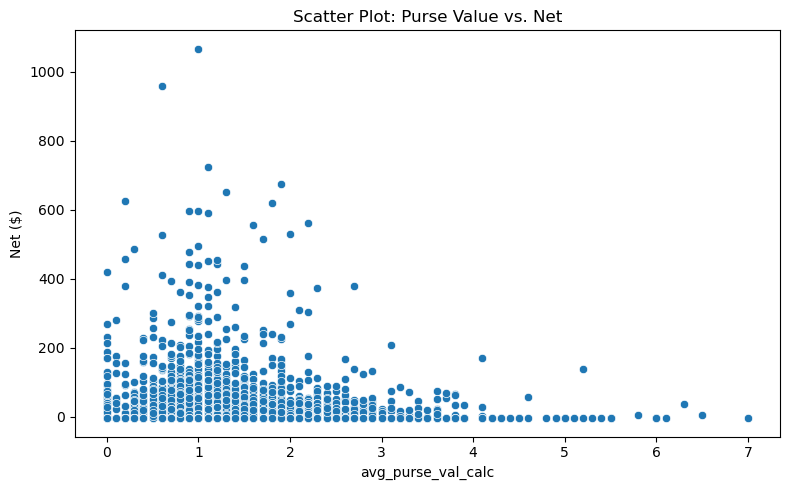


Analysis of avg_purse_val_calc completed.


In [164]:
analyze_purse_values(df)

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_avg_purse_val_calc_distribution(df):
    """
    Plots the distribution of the 'avg_purse_val_calc' column.
    """
    plt.figure(figsize=(8, 5))
    sns.histplot(df["avg_purse_val_calc"].dropna(), bins=50, kde=True, color='blue')
    plt.title("Distribution of avg_purse_val_calc")
    plt.xlabel("avg_purse_val_calc")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

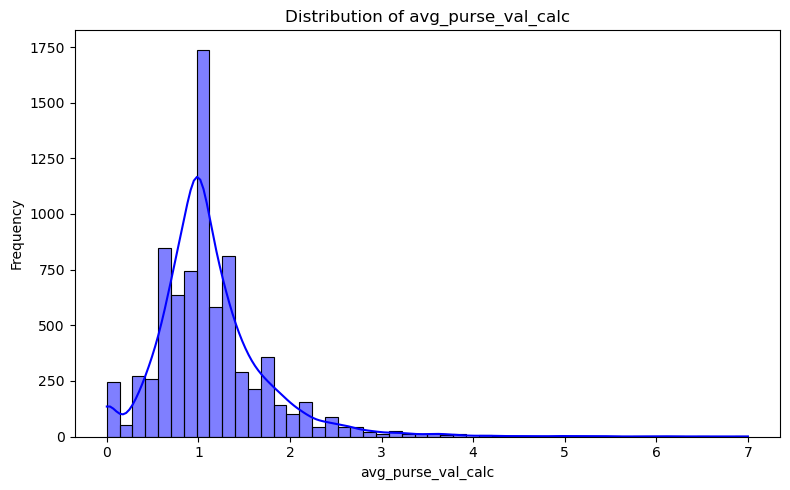

In [166]:
plot_avg_purse_val_calc_distribution(df)

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_avg_purse_val_calc_distribution_fine(df):
    """
    Plots the distribution of the 'avg_purse_val_calc' column in 0.1 increments 
    from 0 to 3, using matplotlib + seaborn.
    """
    # Create the bins array from 0 to 3 in steps of 0.1
    bins = np.arange(0, 3.1, 0.1)  # 3.1 so we include 3.0

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df, 
        x="avg_purse_val_calc", 
        bins=bins, 
        kde=True,
        color='blue'
    )

    # Set x-limit exactly 0 to 3 (optional if you have values > 3)
    plt.xlim(0, 3)

    # Configure x-ticks in 0.1 increments for clarity
    plt.xticks(bins, rotation=45)  # rotation=45 if you want them angled
    plt.title("Distribution of avg_purse_val_calc (0.1 increments, 0–3)")
    plt.xlabel("avg_purse_val_calc")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

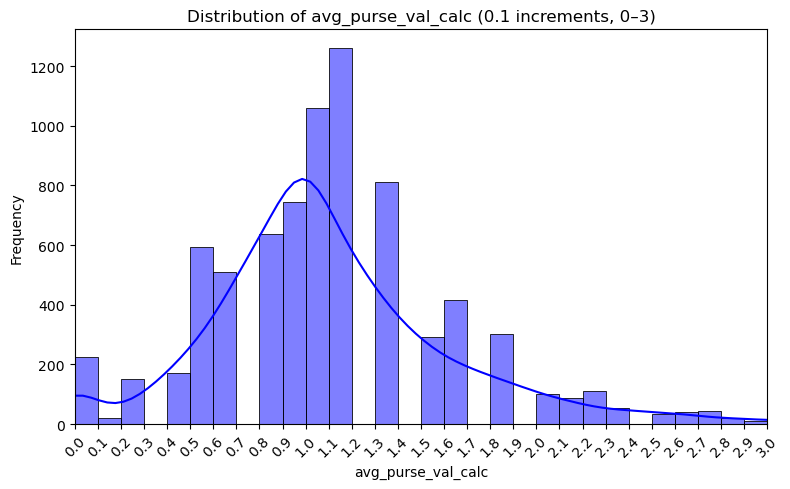

In [168]:
plot_avg_purse_val_calc_distribution_fine(df)

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_net_by_date(df: pd.DataFrame):
    """
    Groups data by date, sums 'net', and plots a line chart
    to see day-to-day net variation.
    Assumes 'race_date' can be converted to datetime.
    """
    # Ensure race_date is datetime
    df["race_date"] = pd.to_datetime(df["race_date"])

    # Group by date and sum net
    daily_net = df.groupby("race_date")["net"].sum().reset_index()

    # Sort by date
    daily_net.sort_values("race_date", inplace=True)

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(daily_net["race_date"], daily_net["net"], marker='o', linewidth=1)
    plt.title("Daily Net Profit/Loss over Time")
    plt.xlabel("Date")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

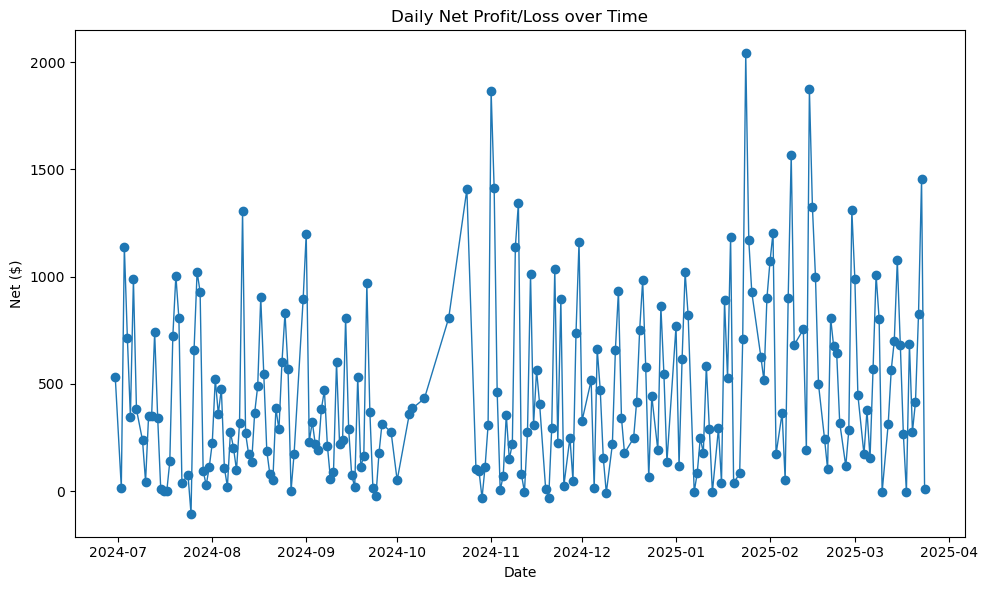

In [170]:
plot_net_by_date(df)

In [171]:
def plot_cumulative_net(df: pd.DataFrame):
    """
    Creates a cumulative sum plot of net over time.
    Useful for seeing overall bankroll growth or decline.
    """
    df["race_date"] = pd.to_datetime(df["race_date"])

    # Group by date, sum net
    daily_net = df.groupby("race_date")["net"].sum().reset_index()
    daily_net.sort_values("race_date", inplace=True)

    # Calculate cumulative sum
    daily_net["cum_net"] = daily_net["net"].cumsum()

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(daily_net["race_date"], daily_net["cum_net"], color='green', linewidth=2)
    plt.title("Cumulative Net Over Time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Net ($)")
    plt.tight_layout()
    plt.show()

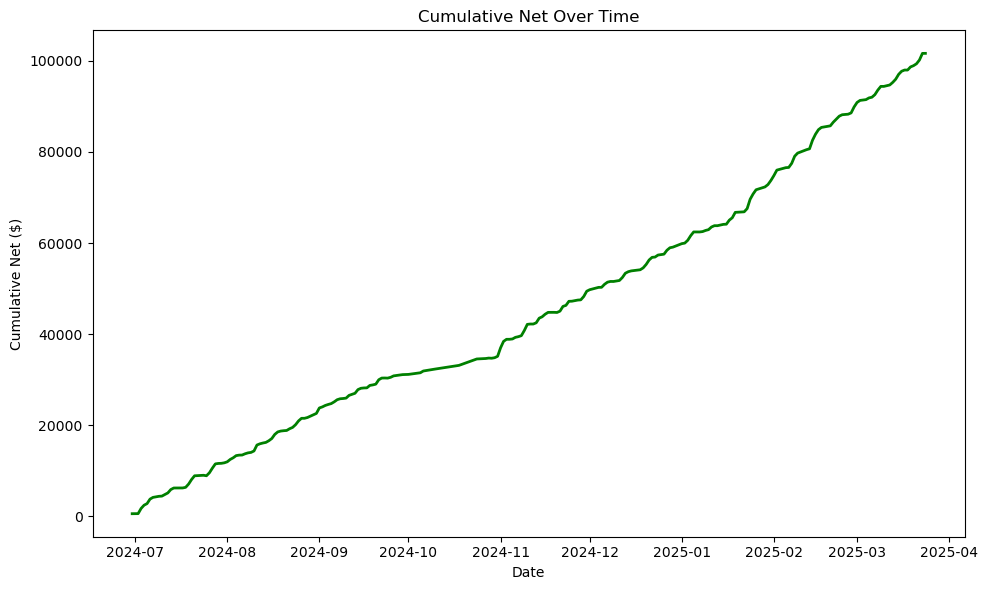

In [172]:
plot_cumulative_net(df)

In [173]:
def plot_monthly_net(df: pd.DataFrame):
    df["race_date"] = pd.to_datetime(df["race_date"])
    df["year_month"] = df["race_date"].dt.to_period("M")  # e.g. 2022-01

    monthly_net = df.groupby("year_month")["net"].sum().reset_index()
    monthly_net["year_month"] = monthly_net["year_month"].astype(str)

    plt.figure(figsize=(10,6))
    plt.bar(monthly_net["year_month"], monthly_net["net"], color='skyblue')
    plt.title("Net Profit/Loss by Month")
    plt.xlabel("Year-Month")
    plt.ylabel("Net ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

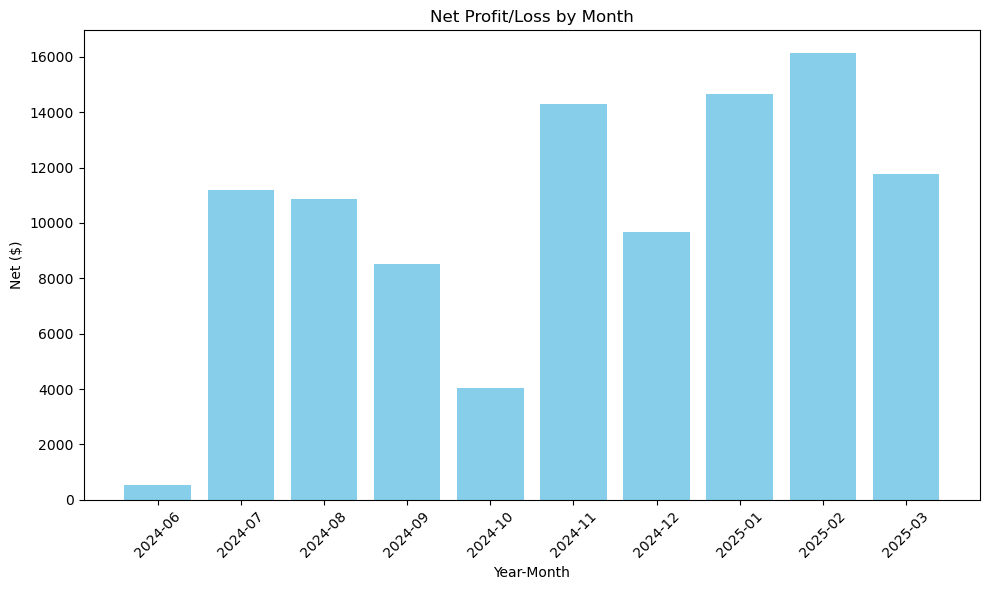

In [174]:
plot_monthly_net(df)

In [175]:
import pandas as pd

def filter_recent_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns only rows from 2023-12-31 onward.
    Ensures 'race_date' is datetime, then filters.
    """
    df["race_date"] = pd.to_datetime(df["race_date"])
    recent_df = df[df["race_date"] >= pd.to_datetime("2023-12-31")]
    return recent_df

In [176]:
import matplotlib.pyplot as plt

def plot_daily_avg_purse(df: pd.DataFrame):
    """
    Groups data by date, calculates the average of avg_purse_val_calc,
    and plots a line chart from left to right over time.
    """
    # Group by date, compute mean
    daily_avg_purse = df.groupby("race_date")["avg_purse_val_calc"].mean().reset_index()
    daily_avg_purse.sort_values("race_date", inplace=True)

    plt.figure(figsize=(10,6))
    plt.plot(daily_avg_purse["race_date"], daily_avg_purse["avg_purse_val_calc"], marker='o')
    plt.title("Daily Average of avg_purse_val_calc")
    plt.xlabel("Date")
    plt.ylabel("Average Purse Calc")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

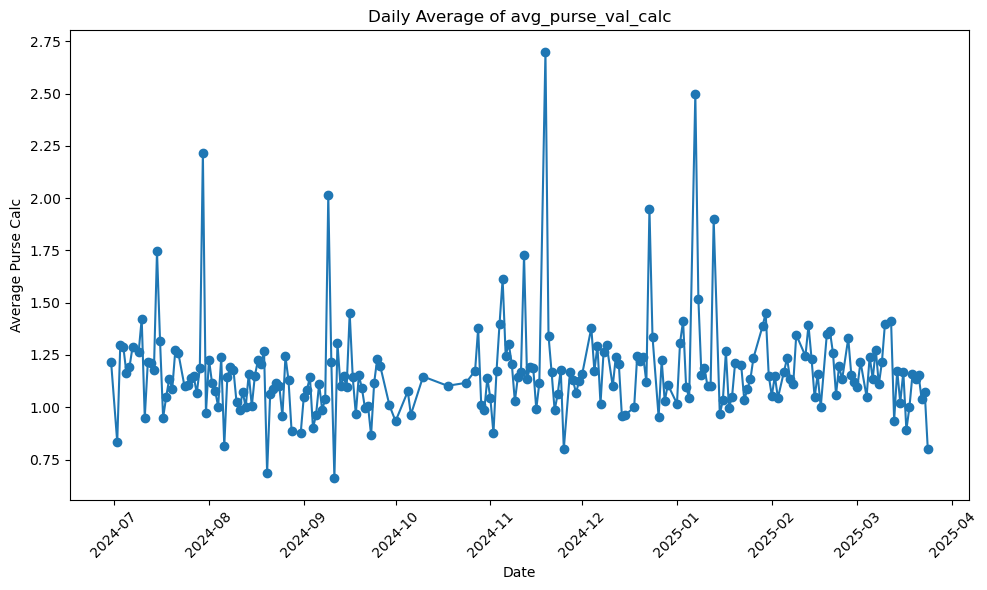

In [177]:
recent_df = filter_recent_data(df)
plot_daily_avg_purse(recent_df)

In [178]:
def plot_purse_and_net(df: pd.DataFrame):
    """
    Plots daily average 'avg_purse_val_calc' and daily sum of 'net'
    on the same figure, with two y-axes.
    """

    # Group by date
    daily_data = df.groupby("race_date").agg({
        "avg_purse_val_calc": "mean",
        "net": "sum"
    }).reset_index()

    daily_data.sort_values("race_date", inplace=True)

    fig, ax1 = plt.subplots(figsize=(10,6))

    # x-values
    x_dates = daily_data["race_date"]
    
    # Plot for avg_purse_val_calc on left y-axis
    color1 = 'tab:blue'
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Avg Purse Calc", color=color1)
    ax1.plot(x_dates, daily_data["avg_purse_val_calc"], color=color1, marker='o', label='Avg Purse Calc')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.tick_params(axis='x', rotation=45)

    # Create a secondary axis for net
    ax2 = ax1.twinx()  
    color2 = 'tab:red'
    ax2.set_ylabel("Net ($)", color=color2)
    ax2.plot(x_dates, daily_data["net"], color=color2, marker='s', label='Net')
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.suptitle("Avg Purse Calc vs Net Over Time")
    fig.tight_layout()
    plt.show()

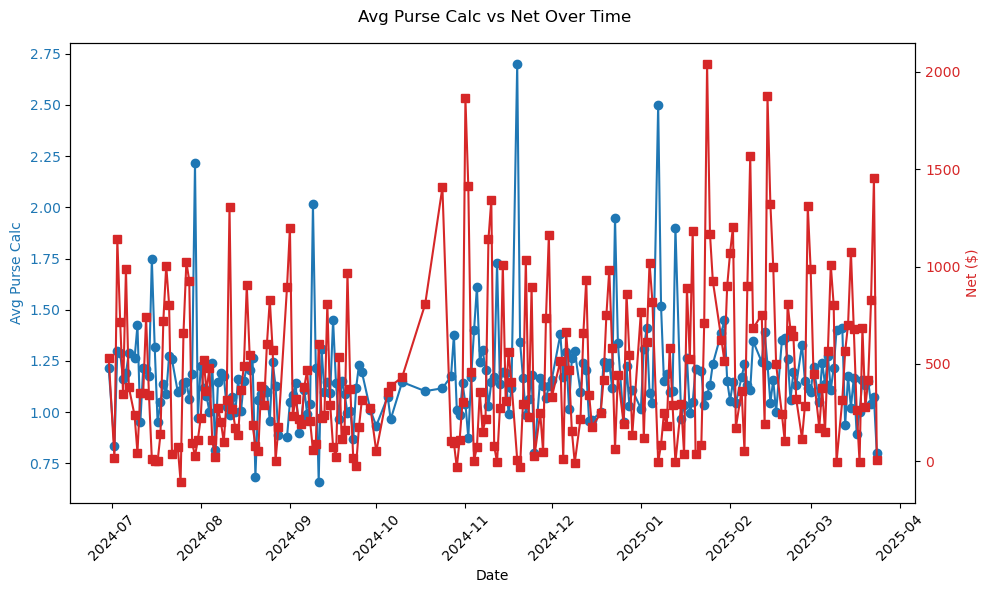

In [179]:
plot_purse_and_net(recent_df)

In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_filtered_net(df: pd.DataFrame, net_threshold: float = 100.0):
    """
    1) Filters the DataFrame to only races where net >= net_threshold
    2) Groups by surface (and optionally bins avg_purse_val_calc)
    3) Plots ROI by surface, ROI by avg_purse_val_calc bin, etc.
    """

    # 1) Filter on net
    filtered_df = df[df["net"] >= net_threshold]
    print(f"Filtering by net >= {net_threshold}, resulting rows: {len(filtered_df)}")

    if filtered_df.empty:
        print("No rows match this filter. Exiting.")
        return

    # 2) Group by surface => average ROI
    surface_roi = filtered_df.groupby("surface")["roi"].mean().sort_values(ascending=False)
    print("\nAverage ROI by Surface (net >= threshold):\n", surface_roi)

    # Plot the ROI by surface
    plt.figure(figsize=(8,5))
    surface_roi.plot(kind="bar", color="skyblue")
    plt.title(f"ROI by Surface (net >= {net_threshold})")
    plt.ylabel("ROI")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3) Binning avg_purse_val_calc for finer analysis
    # Adjust bins to your data range; example from 0..3 in 0.5 increments
    bins = [0, 0.5, 1.0, 1.5, 2.0, 3.0, 9999]
    labels = ["(0-0.5]","(0.5-1.0]","(1.0-1.5]","(1.5-2.0]","(2.0-3.0]","(3.0+)"]
    
    filtered_df["purse_bin"] = pd.cut(filtered_df["avg_purse_val_calc"], bins=bins, labels=labels)

    # Group by purse_bin => average ROI
    purse_bin_roi = filtered_df.groupby("purse_bin")["roi"].mean().sort_values(ascending=False)
    print("\nAverage ROI by Purse Bin (net >= threshold):\n", purse_bin_roi)

    plt.figure(figsize=(8,5))
    purse_bin_roi.plot(kind="bar", color="orange")
    plt.title(f"ROI by Purse Bin (net >= {net_threshold})")
    plt.ylabel("ROI")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 4) If you want a combined grouping (Surface + purse_bin)
    combo_roi = (
        filtered_df
        .groupby(["surface","purse_bin"])["roi"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )
    print("\nROI by Surface + Purse Bin (net >= threshold):\n", combo_roi)

    # Quick barplot via seaborn catplot
    plt.figure(figsize=(10,6))
    sns.barplot(
        x="surface", y="roi", hue="purse_bin",
        data=combo_roi, palette="Set2"
    )
    plt.title(f"ROI by Surface + Purse Bin (net >= {net_threshold})")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.show()

    # Cleanup if needed (remove purse_bin column to leave df intact)
    filtered_df.drop(columns=["purse_bin"], inplace=True, errors='ignore')

Filtering by net >= 100.0, resulting rows: 275

Average ROI by Surface (net >= threshold):
 surface
D    55.529167
T    47.718684
Name: roi, dtype: float64


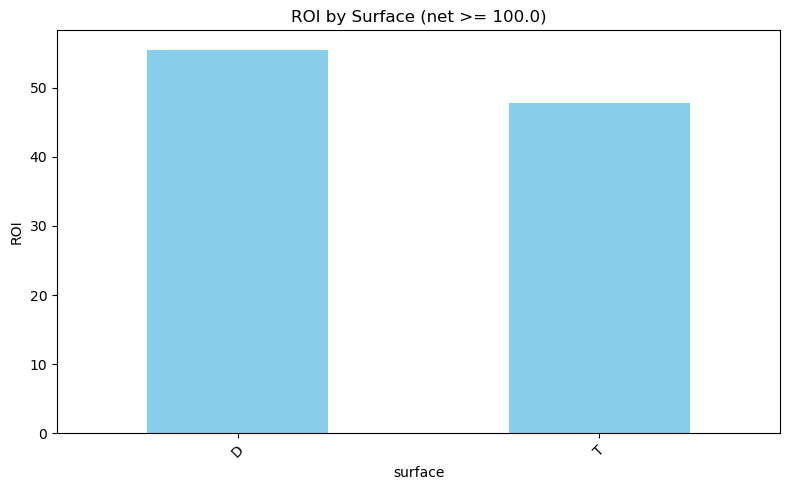


Average ROI by Purse Bin (net >= threshold):
 purse_bin
(1.5-2.0]    61.195000
(0-0.5]      56.400577
(2.0-3.0]    53.791667
(0.5-1.0]    51.920135
(1.0-1.5]    50.844747
(3.0+)       43.133333
Name: roi, dtype: float64


/tmp/ipykernel_1826254/2844565261.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["purse_bin"] = pd.cut(filtered_df["avg_purse_val_calc"], bins=bins, labels=labels)
/tmp/ipykernel_1826254/2844565261.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purse_bin_roi = filtered_df.groupby("purse_bin")["roi"].mean().sort_values(ascending=False)


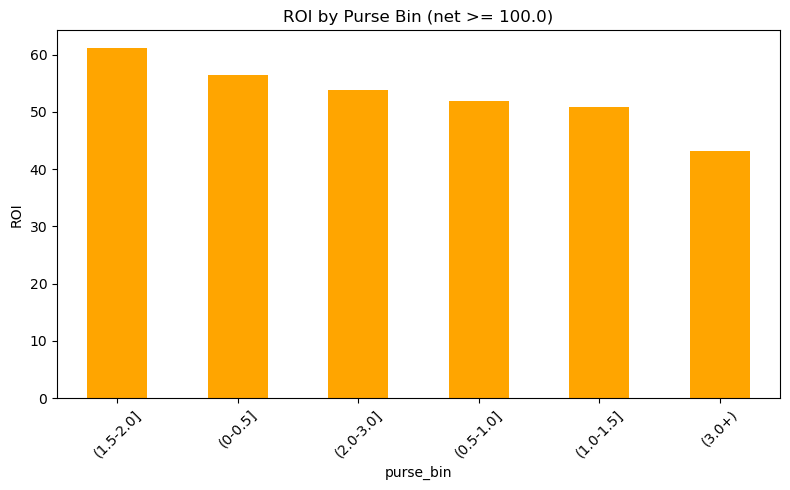


ROI by Surface + Purse Bin (net >= threshold):
    surface  purse_bin        roi
0        T  (1.5-2.0]  70.157143
1        D  (2.0-3.0]  58.543750
2        D  (1.5-2.0]  58.343409
3        D    (0-0.5]  57.024000
4        D  (1.0-1.5]  56.202200
5        T    (0-0.5]  55.550455
6        D  (0.5-1.0]  54.441528
7        T  (0.5-1.0]  47.265256
8        T     (3.0+)  43.133333
9        T  (1.0-1.5]  41.607759
10       T  (2.0-3.0]  34.783333
11       D     (3.0+)        NaN


/tmp/ipykernel_1826254/2844565261.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["surface","purse_bin"])["roi"]


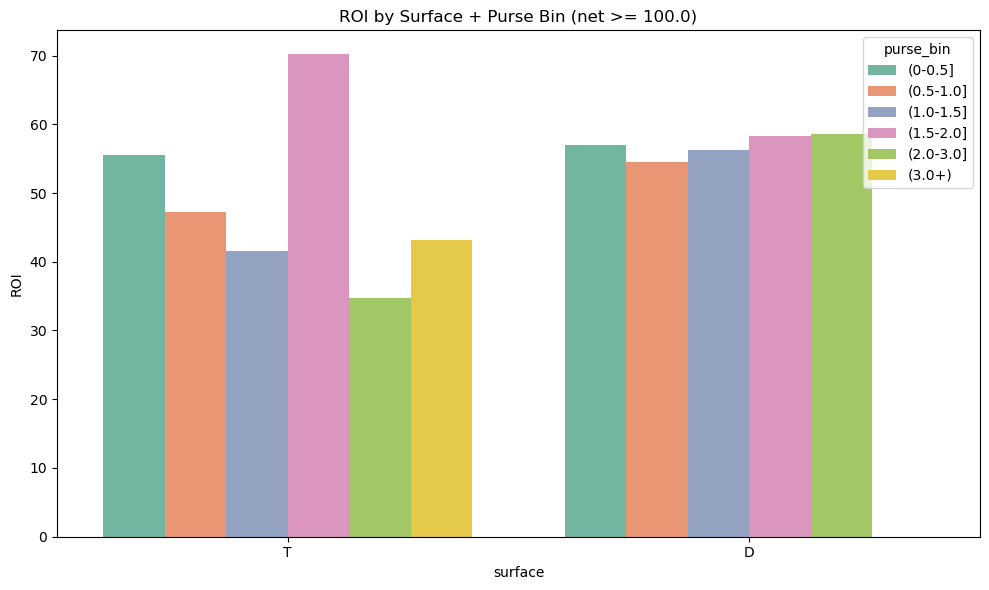

/tmp/ipykernel_1826254/2844565261.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["purse_bin"], inplace=True, errors='ignore')


In [181]:
# Suppose 'df' is your DataFrame of bet results
analyze_filtered_net(df, net_threshold=100.0)

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_race_type(df: pd.DataFrame):
    """
    Analyzes how 'race_type' (a column in df) relates to 
    ROI, net, and hit_flag. Assumes df includes columns:
      - 'race_type'
      - 'roi'
      - 'net'
      - 'hit_flag' (0 or 1)
      - etc.
    """

    # 1) Basic groupby stats by race_type
    group_stats = df.groupby("race_type").agg({
        "roi": "mean",
        "net": ["mean", "count"],
        "hit_flag": "mean"
    })
    group_stats.columns = ["mean_roi", "mean_net", "count_races", "hit_rate"]
    group_stats = group_stats.sort_values("mean_roi", ascending=False)
    print("Summary by race_type:")
    print(group_stats)

    # 2) Bar chart of average ROI by race_type
    plt.figure(figsize=(8,5))
    sns.barplot(
        x=group_stats.index,
        y="mean_roi",
        data=group_stats.reset_index(), 
        color="skyblue"
    )
    plt.title("Average ROI by Race Type")
    plt.ylabel("ROI")
    plt.xlabel("Race Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3) Distribution of 'net' by race_type (boxplot or violin plot)
    plt.figure(figsize=(9,6))
    sns.boxplot(x="race_type", y="net", data=df, showfliers=False)
    plt.title("Net Distribution by Race Type (Outliers Hidden)")
    plt.xlabel("Race Type")
    plt.ylabel("Net ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optional: a violin plot can sometimes give more insight
    plt.figure(figsize=(9,6))
    sns.violinplot(x="race_type", y="net", data=df, cut=0)
    plt.title("Net Distribution by Race Type (Violin Plot)")
    plt.xlabel("Race Type")
    plt.ylabel("Net ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nAnalysis by race_type complete. See plots above.")

Summary by race_type:
           mean_roi   mean_net  count_races  hit_rate
race_type                                            
MDN        4.155570  16.622280         2061  0.348860
ALW        3.388113  13.552453          803  0.330012
CLM        3.002874  12.011494         4249  0.316545
STK        1.967102   7.868407          697  0.329986


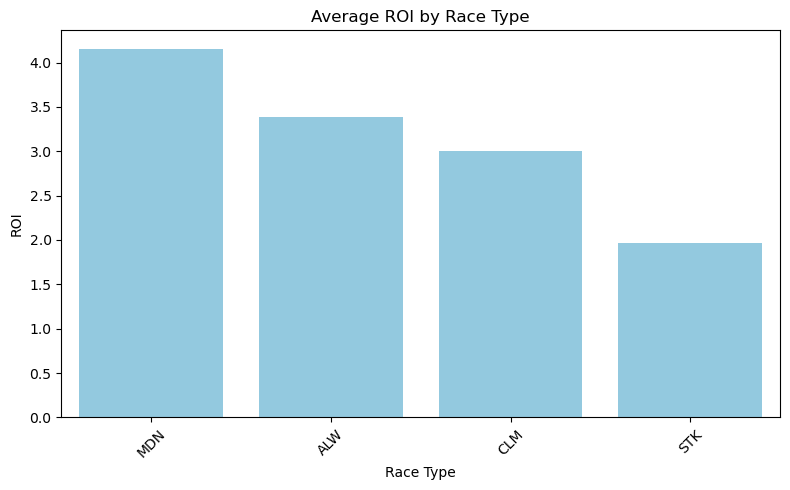

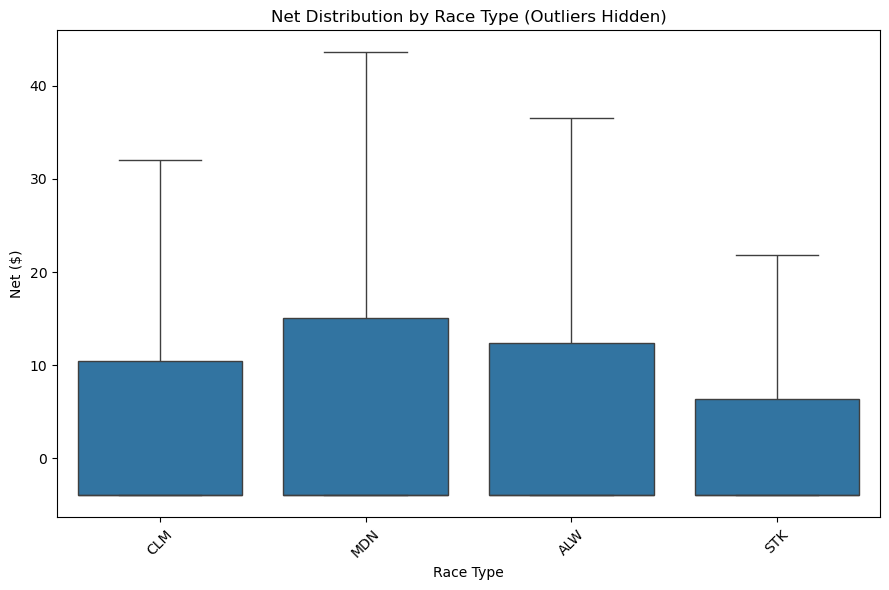

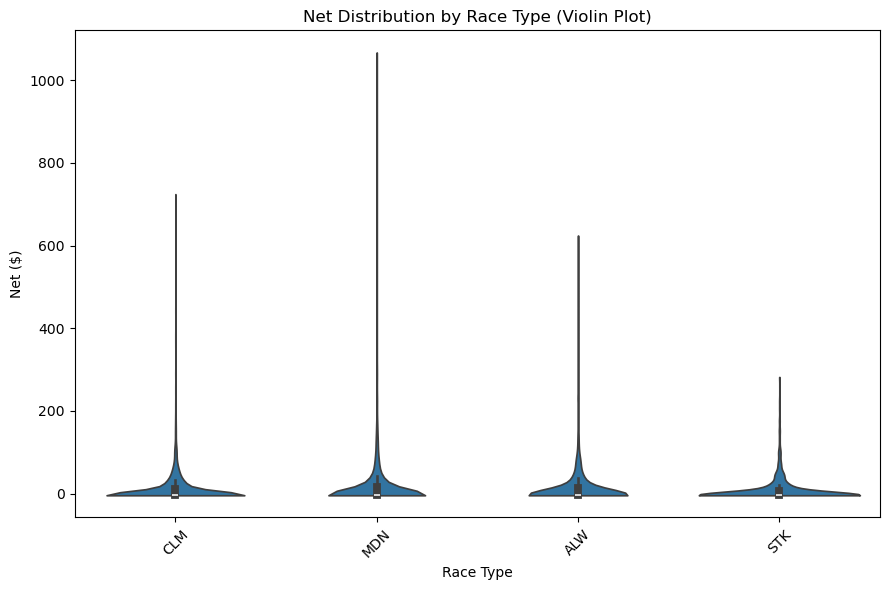


Analysis by race_type complete. See plots above.


In [183]:
analyze_race_type(df)

<Axes: xlabel='field_size'>

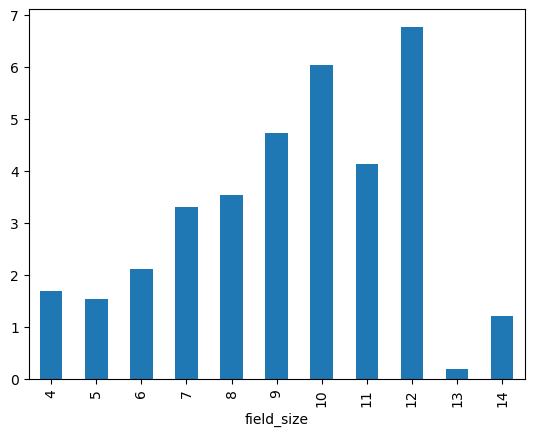

In [184]:
df.groupby("field_size")["roi"].mean().plot.bar()

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_field_size(df: pd.DataFrame, field_col: str = "field_size"):
    """
    Analyzes how the number of horses in a race (field_size) 
    relates to ROI and Net outcomes.
    
    :param df:         DataFrame containing 'field_size', 'roi', and 'net' columns
    :param field_col:  Name of the column that holds the field size info
    """

    # 1) Basic groupby stats by field size
    #    We'll look at mean ROI, mean net, how many races, etc.
    group_stats = (
        df.groupby(field_col)
          .agg({
              "roi": "mean",
              "net": "mean",
              "hit_flag": "mean",
              "race_date": "count"  # count how many races in each group
          })
          .rename(columns={"race_date": "num_races",
                           "roi": "mean_roi",
                           "net": "mean_net",
                           "hit_flag": "hit_rate"})
          .sort_values(field_col)
    )
    
    print("\nSummary by Field Size:")
    print(group_stats)

    # 2) Bar chart: mean ROI by field size
    plt.figure(figsize=(8,5))
    group_stats["mean_roi"].plot(kind="bar", color="skyblue")
    plt.title("Average ROI by Field Size")
    plt.xlabel("Field Size")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.show()

    # 3) Bar chart: mean Net by field size
    plt.figure(figsize=(8,5))
    group_stats["mean_net"].plot(kind="bar", color="orange")
    plt.title("Average Net by Field Size")
    plt.xlabel("Field Size")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

    # 4) If you want a distribution of net by field size (boxplot or violin)
    plt.figure(figsize=(9,6))
    sns.boxplot(x=field_col, y="net", data=df, showfliers=False)
    plt.title("Net Distribution by Field Size (Outliers Hidden)")
    plt.xlabel("Field Size")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

    print("\nAnalysis of Field Size complete.")


Summary by Field Size:
            mean_roi   mean_net  hit_rate  num_races
field_size                                          
4           1.696773   6.787093  0.308980        657
5           1.543553   6.174212  0.354291       1002
6           2.121586   8.486344  0.354241       1403
7           3.312929  13.251717  0.347313       1526
8           3.536924  14.147696  0.308003       1237
9           4.733944  18.935777  0.306145        895
10          6.048403  24.193611  0.314236        576
11          4.127466  16.509865  0.273649        296
12          6.776286  27.105146  0.266990        206
13          0.195833   0.783333  0.166667          6
14          1.212500   4.850000  0.166667          6


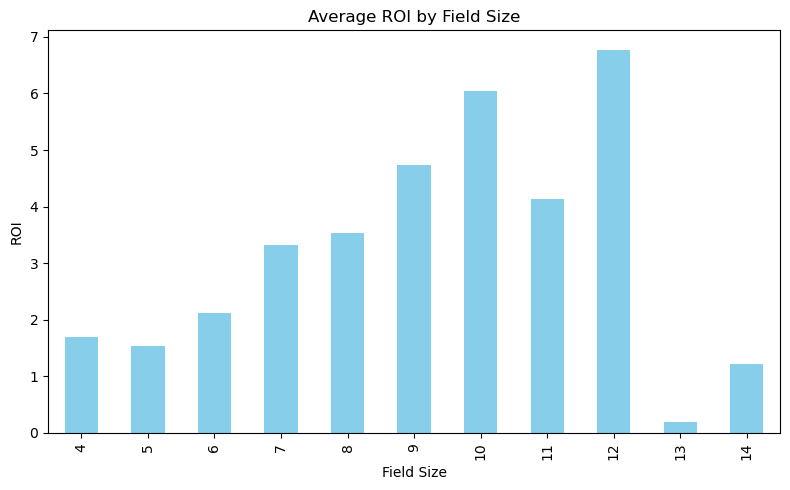

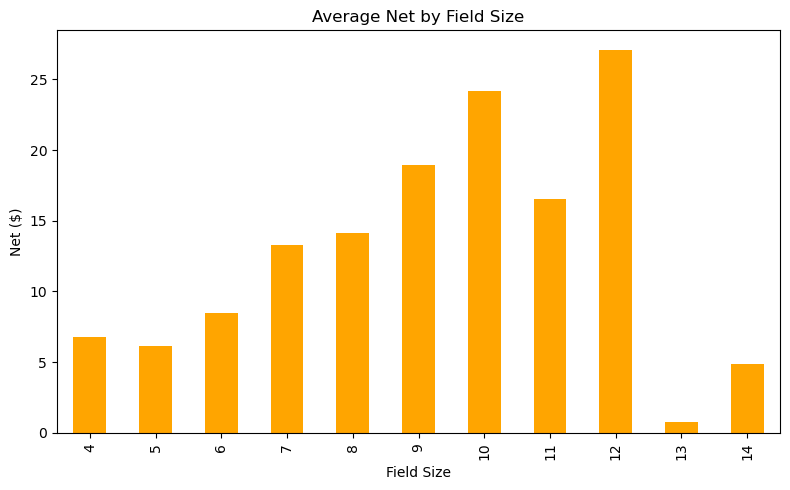

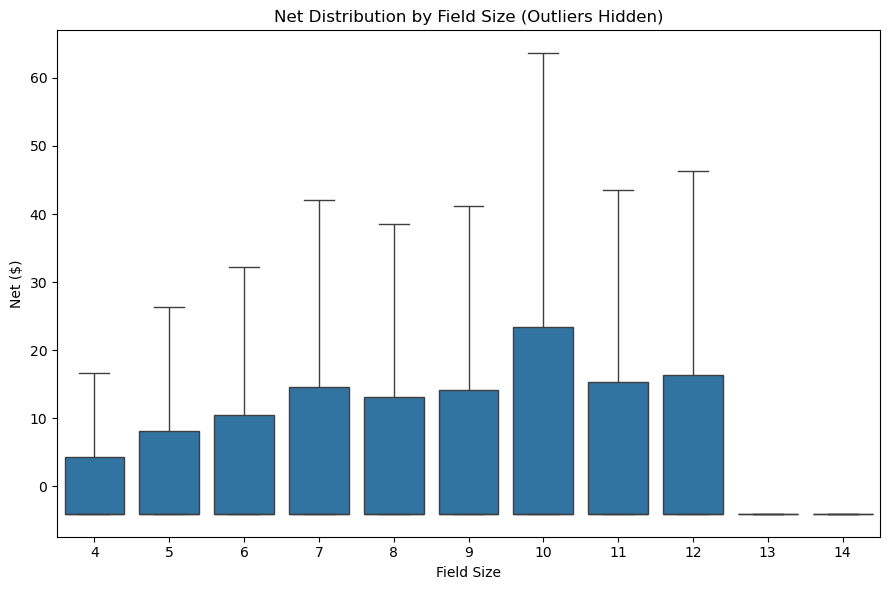


Analysis of Field Size complete.


In [186]:
analyze_field_size(df, field_col="field_size")

In [72]:
# Load historical and future data from Spark.
historical_df = global_speed_score.filter(F.col("data_flag") == "historical")
future_df = global_speed_score.filter(F.col("data_flag") == "future")


In [73]:
global_speed_score.count()

386165

In [74]:
future_df.count()

868

In [75]:
historical_df_spark = (
    historical_df_spark
    .withColumn("race_date_str", F.date_format("race_date", "yyyy-MM-dd"))
    .withColumn(
        "group_id",
        F.concat(
            F.col("course_cd"),
            F.lit("_"),
            F.col("race_date_str"),
            F.lit("_"),
            F.col("race_number").cast("string")
            )
        )
    )


In [76]:
race_sizes_df = (
    historical_df_spark.groupBy("group_id")
      .agg(F.count("*").alias("num_horses"))
)

In [77]:


# 2) Group by the computed "num_horses" to find how many races have that count
race_size_distribution_df = (
    race_sizes_df
    .groupBy("num_horses")
    .count()  # how many races have that particular horse count
    .withColumnRenamed("count", "num_races")
)

# 3) Optionally compute total number of races, then compute percentages
total_races = race_size_distribution_df.agg(F.sum("num_races")).collect()[0][0]

race_size_distribution_df = (
    race_size_distribution_df
    .withColumn("pct_of_races", F.round((F.col("num_races") / F.lit(total_races)) * 100, 2))
    .orderBy("num_horses")
)

race_size_distribution_df.show(200, truncate=False)

+----------+---------+------------+
|num_horses|num_races|pct_of_races|
+----------+---------+------------+
|3         |4        |0.02        |
|4         |22       |0.12        |
|5         |1796     |10.19       |
|6         |3862     |21.91       |
|7         |4170     |23.66       |
|8         |3165     |17.96       |
|9         |2063     |11.71       |
|10        |1396     |7.92        |
|11        |604      |3.43        |
|12        |495      |2.81        |
|13        |26       |0.15        |
|14        |19       |0.11        |
|17        |1        |0.01        |
+----------+---------+------------+



In [78]:
from src.data_preprocessing.data_prep2.data_healthcheck import time_series_data_healthcheck
import pprint

In [79]:
healthcheck_report = time_series_data_healthcheck(global_speed_score)
pprint.pprint(healthcheck_report)

{'categorical_columns': {'columns': ['course_cd',
                                     'group_id',
                                     'axciskey',
                                     'race_id',
                                     'saddle_cloth_number',
                                     'horse_name',
                                     'sex',
                                     'equip',
                                     'previous_surface',
                                     'med',
                                     'surface',
                                     'trk_cond',
                                     'race_type',
                                     'stk_clm_md',
                                     'turf_mud_mark',
                                     'data_flag',
                                     'layoff_cat',
                                     'track_name',
                                     'race_date_str'],
                         'suggested_action'

In [65]:
import pyspark.sql.functions as F

# Identify numeric columns (float, double, int, etc.)
numeric_columns = [
    c for c, t in global_speed_score.dtypes
    if t in ("double", "float", "int", "bigint", "decimal")
]

# Build an expression that sums up invalid entries in each numeric column
summary_exprs = []
for c in numeric_columns:
    summary_exprs.append(
        F.sum(
            F.when(
                F.isnan(F.col(c)) |
                F.col(c).isNull() |
                (F.col(c) == float("inf")) |
                (F.col(c) == -float("inf")),
                1
            ).otherwise(0)
        ).alias(c)
    )

# Produce a single row that shows how many bad values each numeric column has
summary = global_speed_score.select(*summary_exprs)
summary.show(truncate=False)

+-----------+------------+--------+------------+--------+------------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------+--------+--------+--------+---------+------------------+--------+--------+--------+--------+----------------+----------------+-------+-------+-------+-------+--------+--------+-------+-------+-------+-------+------------------+----------+----------+----------+----------+-----------------+-----------------+-----------------+--------------+------+----------+-----------------+-----------------+-----+------+------+----------+---------+---------+-------+-----+---------------+---------+----------------+----------------+-------------------+-------------------+-----------------+-----------------+-------------------+--------+------------------+-------+----------+-------+---------+--------+----------+------------+--------------------+-------------+-------------+---------+-----------+------

In [68]:
import pyspark.sql.functions as F

# 1) Identify numeric columns
numeric_columns = [
    c for c, t in global_speed_score.dtypes
    if t in ("double", "float", "int", "bigint", "decimal")
]

# 2) For each numeric column, calculate counts for each type of “bad” value
results = []
for col_name in numeric_columns:
    null_count = global_speed_score.filter(F.col(col_name).isNull()).count()
    nan_count = global_speed_score.filter(F.isnan(col_name)).count()            # only valid for float/double
    pos_inf_count = global_speed_score.filter(F.col(col_name) == float("inf")).count()
    neg_inf_count = global_speed_score.filter(F.col(col_name) == -float("inf")).count()

    results.append((col_name, null_count, nan_count, pos_inf_count, neg_inf_count))

# 3) Convert the list to a Spark DataFrame
bad_counts_df = (
    spark.createDataFrame(
        results, 
        ["column", "null_count", "nan_count", "pos_inf_count", "neg_inf_count"]
    )
)

# 4) Show the breakdown
bad_counts_df.show(250, truncate=False)

+------------------------+----------+---------+-------------+-------------+
|column                  |null_count|nan_count|pos_inf_count|neg_inf_count|
+------------------------+----------+---------+-------------+-------------+
|race_number             |0         |0        |0            |0            |
|class_rating            |0         |0        |0            |0            |
|horse_id                |0         |0        |0            |0            |
|official_fin            |536       |0        |0            |0            |
|par_time                |0         |0        |0            |0            |
|running_time            |0         |0        |0            |0            |
|total_distance_ran      |0         |0        |0            |0            |
|avgtime_gate1           |0         |0        |0            |0            |
|avgtime_gate2           |0         |0        |0            |0            |
|avgtime_gate3           |0         |0        |0            |0            |
|avgtime_gat

In [70]:
# global_speed_score.cols
num_rows = global_speed_score.count()            # full scan to count rows
num_cols = len(global_speed_score.columns)       # simply the length of the column list
print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 133030, Columns: 150


In [ ]:
from pyspark.sql import functions as F

for col in future_df.columns:
    null_count = future_df.filter(F.col(col).isNull()).count()
    if null_count > 0:
        print(f"{col}: {null_count} null values")

In [ ]:
for col in historical_df_spark.columns:
    null_count = historical_df_spark.filter(F.col(col).isNull()).count()
    if null_count > 0:
        print(f"{col}: {null_count} null values")

In [ ]:
global_speed_score.printSchema()

In [ ]:
# Separate historical and future data
historical_df = global_speed_score.filter(F.col("data_flag") == "historical")
future_df = global_speed_score.filter(F.col("data_flag") == "future")


In [ ]:
from pyspark.sql.types import FloatType, DoubleType
import pyspark.sql.functions as F

# Get all numeric columns (float and double)
numeric_cols = [field.name for field in global_speed_score.schema.fields 
                if field.dataType.typeName() in ['double', 'float']]

cols_with_issues = []

for col_name in numeric_cols:
    # Count NaN values
    nan_count = global_speed_score.filter(F.isnan(F.col(col_name))).count()
    # Count positive infinity values
    pos_inf_count = global_speed_score.filter(F.col(col_name) == float("inf")).count()
    # Count negative infinity values
    neg_inf_count = global_speed_score.filter(F.col(col_name) == float("-inf")).count()
    total_issues = nan_count + pos_inf_count + neg_inf_count
    if total_issues > 0:
        cols_with_issues.append({
            "column": col_name,
            "total_issues": total_issues,
            "nan_count": nan_count,
            "pos_inf_count": pos_inf_count,
            "neg_inf_count": neg_inf_count
        })

print("Numeric columns with NaN or Infinity values:")
for info in cols_with_issues:
    print(f"{info['column']}: total issues={info['total_issues']} (NaN: {info['nan_count']}, +Inf: {info['pos_inf_count']}, -Inf: {info['neg_inf_count']})")

In [ ]:
count_hist = global_speed_score.filter(F.col("data_flag") == "historical").count()
count_fut = global_speed_score.filter(F.col("data_flag") == "future").count()
count_total = global_speed_score.count()

print(f"Final DF total count: {count_total}")
print(f"Final DF count for historical: {count_hist}")
print(f"Final DF count for future: {count_fut}")

In [ ]:
# Show basic descriptive stats for global_speed_score
global_speed_score_stats = global_speed_score.select("global_speed_score_iq").describe()
global_speed_score_stats.show()

In [ ]:
global_speed_score_quantiles = global_speed_score.select("global_speed_score_iq").summary()
global_speed_score_quantiles.show()

In [ ]:
# Show count, mean, stddev, min, 25%, 50%, 75%, and max
global_speed_score_quantiles = global_speed_score.select("global_speed_score_iq").summary()
global_speed_score_quantiles.show()

In [ ]:
import pyspark.sql.functions as F

df_bins = (
    global_speed_score.withColumn("score_bin", F.floor(F.col("global_speed_score_iq") / 10) * 10)
      .groupBy("score_bin")
      .count()
      .orderBy("score_bin")
)

df_bins.show(100, truncate=False)

In [ ]:
# Example for standardized_score with bin size = 0.5
df_bins_std = (
    global_speed_score.withColumn("score_bin", F.floor(F.col("global_speed_score_iq") / 0.5) * 0.5)
      .groupBy("score_bin")
      .count()
      .orderBy("score_bin")
)
df_bins_std.show(200, truncate=False)

In [ ]:
import matplotlib.pyplot as plt

# Convert the column to an RDD and use the histogram function
hist_result = (
    global_speed_score.select("global_speed_score_iq")
      .rdd
      .flatMap(lambda x: x)  # flatten out the column values
      .histogram(10)         # 10 bins by default
)

# hist_result returns a tuple (bins, counts)
# bins: list of bin boundaries
# counts: list of counts in each bin

bins = hist_result[0]
counts = hist_result[1]

plt.figure(figsize=(8, 5))
plt.bar(x=bins[:-1], height=counts, width=(bins[1] - bins[0]) * 0.9)
plt.xlabel("global_speed_score")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Convert the column to an RDD and use the histogram function
hist_result = (
    global_speed_score.select("global_speed_score_iq")
      .rdd
      .flatMap(lambda x: x)  # flatten out the column values
      .histogram(10)         # 10 bins by default
)

# hist_result returns a tuple (bins, counts)
# bins: list of bin boundaries
# counts: list of counts in each bin

bins = hist_result[0]
counts = hist_result[1]

plt.figure(figsize=(8, 5))
plt.bar(x=bins[:-1], height=counts, width=(bins[1] - bins[0]) * 0.9)
plt.xlabel("global_speed_score_iq")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

In [ ]:
pdf = global_speed_score.select("global_speed_score_iq").toPandas()

plt.figure(figsize=(8, 5))
plt.hist(pdf["global_speed_score_iq"], bins=50, edgecolor='black')
plt.xlabel("global_speed_score_iq")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# If the DataFrame is huge, take a sample to avoid OOM on driver
pdf = (global_speed_score
       .select("global_speed_score_iq")
       .dropna()
       .sample(withReplacement=False, fraction=0.01, seed=42)  # e.g., 1% sample
       .toPandas()
      )

plt.figure(figsize=(8, 5))
plt.hist(pdf["global_speed_score_iq"], bins=350, edgecolor='black')
plt.title("Distribution of global_speed_score_iq (sampled)")
plt.xlabel("global_speed_score_iq")
plt.ylabel("Count")
plt.show()

In [ ]:
import pyspark.sql.functions as F

high_scores_df = (
    global_speed_score
    .select("horse_id", "horse_name", "global_speed_score_iq")
    .filter(
        (F.col("global_speed_score_iq") >= 110) &
        (F.col("global_speed_score_iq") <= 140)
    )
)

# Show them
high_scores_df.show(truncate=False)

# Or collect to the driver if you want to iterate in Python
results = high_scores_df.collect()
for row in results:
    print(row["horse_id"], row["horse_name"], row["global_speed_score_iq"])

In [ ]:
# Group by what should be your PK columns
dup_check_df = (
    global_speed_score.groupBy("course_cd", "race_date", "race_number", "horse_id")
      .count()
      .filter("count > 1")  # means there's more than one row for that key
)

dup_check_df.show(truncate=False)

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_field_size(df: pd.DataFrame, field_col: str = "field_size"):
    """
    Analyzes how the number of horses in a race (field_size) 
    relates to ROI and Net outcomes.
    
    :param df:         DataFrame containing 'field_size', 'roi', and 'net' columns
    :param field_col:  Name of the column that holds the field size info
    """

    # 1) Basic groupby stats by field size
    #    We'll look at mean ROI, mean net, how many races, etc.
    group_stats = (
        df.groupby(field_col)
          .agg({
              "roi": "mean",
              "net": "mean",
              "hit_flag": "mean",
              "race_date": "count"  # count how many races in each group
          })
          .rename(columns={"race_date": "num_races",
                           "roi": "mean_roi",
                           "net": "mean_net",
                           "hit_flag": "hit_rate"})
          .sort_values(field_col)
    )
    
    print("\nSummary by Field Size:")
    print(group_stats)

    # 2) Bar chart: mean ROI by field size
    plt.figure(figsize=(8,5))
    group_stats["mean_roi"].plot(kind="bar", color="skyblue")
    plt.title("Average ROI by Field Size")
    plt.xlabel("Field Size")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.show()

    # 3) Bar chart: mean Net by field size
    plt.figure(figsize=(8,5))
    group_stats["mean_net"].plot(kind="bar", color="orange")
    plt.title("Average Net by Field Size")
    plt.xlabel("Field Size")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

    # 4) If you want a distribution of net by field size (boxplot or violin)
    plt.figure(figsize=(9,6))
    sns.boxplot(x=field_col, y="net", data=df, showfliers=False)
    plt.title("Net Distribution by Field Size (Outliers Hidden)")
    plt.xlabel("Field Size")
    plt.ylabel("Net ($)")
    plt.tight_layout()
    plt.show()

    print("\nAnalysis of Field Size complete.")

In [88]:
import pandas as pd

def add_field_size_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each (course_cd, race_date, race_number) group, count how many rows (horses) appear.
    Adds a new column 'field_size' to df indicating that race's total number of horses.
    
    Example usage:
      df = add_field_size_column(df)
    """
    # Use groupby transform to count the rows per group
    df["field_size"] = (
        df
        .groupby(["course_cd", "race_date", "race_number"])["horse_id"]  # or any unique per-horse column
        .transform("count")
    )

    return df

In [89]:
df = add_field_size_column(df)
print(df[["course_cd","race_date","race_number","horse_id","field_size"]].head())

KeyError: 'Column not found: horse_id'

In [87]:
analyze_field_size(df, field_col="field_size")

KeyError: 'field_size'

In [ ]:
# Count number of races
# Count the number of unique races
race_count = (
    global_speed_score
    .select("course_cd", "race_date", "race_number")
    .distinct()  # Get unique race combinations
    .count()
)

# Print the number of unique races
print(f"Total number of races: {race_count}")

In [ ]:
from pyspark.sql import functions as F

# Check if the column exists, and drop it if it does
if "horse_count" in global_speed_score.columns:
    global_speed_score = global_speed_score.drop("horse_count")

In [ ]:
# Count the number of horses in each race
race_horse_counts = (
    global_speed_score
    .groupBy("course_cd", "race_date", "race_number")
    .agg(F.count("saddle_cloth_number").alias("horse_count"))  # Count horses per race
)

# Join the count back to the main DataFrame
global_speed_score = global_speed_score.join(race_horse_counts, on=["course_cd", "race_date", "race_number"], how="left")

In [ ]:
# Define the race to filter (modify these values as needed)
selected_course = "TOP"
selected_date = "2025-03-01"  # Adjust as needed
selected_race = 2  # Adjust as needed

# Filter and sort the DataFrame
filtered_race = (
    global_speed_score
    .filter(
        (F.col("course_cd") == selected_course) &
        (F.col("race_date") == selected_date) &
        (F.col("race_number") == selected_race)
    )
    .select(
        "course_cd", 
        "race_date", 
        "race_number", 
        "horse_name", 
        "saddle_cloth_number", 
        "horse_count"
    )
    .orderBy(F.col("saddle_cloth_number").asc())  # Sort by saddle_cloth_number
)

# Show the filtered race details
filtered_race.show(truncate=False)

In [ ]:
# Filter the DataFrame for the specific race.
race_df = speed_score.filter(
    (F.col("course_cd") == "TGP") &
    (F.col("race_date") == F.lit("2025-02-23").cast("date")) &
    (F.col("race_number") == 2)
)

# Select and order the columns of interest.
race_df.select("saddle_cloth_number", "horse_name", "course_cd", "race_date", "race_number") \
       .orderBy("saddle_cloth_number") \
       .show(truncate=False)

In [ ]:
horse_embedding.printSchema()

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define the list of TPD tracks you want to filter for
tpd_tracks = [
    'CNL', 'SAR', 'PIM', 'TSA', 'BEL', 'MVR', 'TWO', 'CLS', 'KEE', 'TAM', 'TTP', 'TKD', 
    'ELP', 'PEN', 'HOU', 'DMR', 'TLS', 'AQU', 'MTH', 'TGP', 'TGG', 'CBY', 'LRL', 
    'TED', 'IND', 'CTD', 'ASD', 'TCD', 'LAD', 'TOP'
]

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .filter(F.col("course_cd").isin(tpd_tracks))  # <-- Track filter applied here
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Show races with non-contiguous saddle cloth numbers from the specified tracks
races_with_gaps.show()

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define the specific track(s) you want to filter for
selected_tracks = ['TOP']  # Change this to filter for different tracks

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .filter(F.col("course_cd").isin(selected_tracks))  # <-- Filter for specific track(s)
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Show races with non-contiguous saddle cloth numbers for the selected track(s)
races_with_gaps.show()

Approach

>1.	Find races where saddle cloth numbers are non-contiguous (already identified in races_with_gaps).

>2.	Use that list to filter the main dataset (horse_embedding) and retrieve the horses that are present in those races.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Now, retrieve all horses in these races so we can see what saddle cloth numbers are present
horses_in_missing_races = (
    horse_embedding
    .join(races_with_gaps, ["course_cd", "race_date", "race_number"])  # Join to get only races with gaps
    .select("course_cd", "race_date", "race_number", "horse_name", "saddle_cloth_number")
    .orderBy("course_cd", "race_date", "race_number", "saddle_cloth_number")  # Order for readability
)

# Show results
horses_in_missing_races.show(50, truncate=False)

In [ ]:
# Filter the DataFrame for the specific race.
race_df = horse_enhanced.filter(
    (F.col("course_cd") == "AQU") &
    (F.col("race_date") == F.lit("2025-02-23").cast("date")) &
    (F.col("race_number") == 10)
)

# Select and order the columns of interest.
race_df.select("saddle_cloth_number", "horse_name", "course_cd", "race_date", "race_number") \
       .orderBy("saddle_cloth_number") \
       .show(truncate=False)